In [1]:
import time
import matplotlib.pyplot as plt
import torch
import numpy as np
from laplacian_py import laplacian_solver
from laplacian_py.network import LaplaceNet, compute_loss
print(laplacian_solver.__dir__())
from laplacian_py.network import LaplacianSolver

res = 200
# max_val = 10*res//5
max_val = 50

values = .99*max_val*torch.ones((res, res),dtype=torch.float32, device='cuda')
boundary_conditions = torch.zeros((res,res),dtype=torch.float32, device='cuda')
boundary_types = torch.zeros((res,res),dtype=torch.float32, device='cuda')


# obj1_ind1 = int(res*18/30)
# obj1_ind2 = int(res*2/3)
# obj1_ind3 = int(res*0)
# obj1_ind4 = int(res*2/3)
# boundary_conditions[obj1_ind1:obj1_ind2, obj1_ind3:obj1_ind4] = max_val
# boundary_types[obj1_ind1:obj1_ind2, obj1_ind3:obj1_ind4] = 1.0

# obj2_ind1 = int(res*3/12)
# obj2_ind2 = int(res*4/12)
# obj2_ind3 = int(res*1/3)
# obj2_ind4 = int(res*28/30)
# boundary_conditions[obj2_ind1:obj2_ind2, obj2_ind3:obj2_ind4] = max_val
# boundary_types[obj2_ind1:obj2_ind2, obj2_ind3:obj2_ind4] = 1.0



cost_scale = .001
cost = cost_scale*torch.ones(res,res,dtype=torch.float32, device='cuda')
safe = res//15
# cost[max(obj1_ind1-safe, 0):min(obj1_ind2+safe, res-1), max(obj1_ind3-safe, 0):min(obj1_ind4+safe, res-1)] = .3
# cost[max(obj2_ind1-safe, 0):min(obj2_ind2+safe, res-1), max(obj2_ind3-safe, 0):min(obj2_ind4+safe, res-1)] = .3


# boundary_conditions[2*60:2*80, 2*60:2*80] = 0
# boundary_types[2*60:2*80, 2*60:2*80] = 1.0

# goals
# ind1 = int(res*2/30)
# ind2 = int(res*2/30)
# boundary_conditions[ind1, ind2] = 0.0
# boundary_types[ind1, ind2] = 1.0
ind1 = int(res*6/30)
ind2 = int(res*22/30)
boundary_conditions[ind1, ind2] = 0.0
boundary_types[ind1, ind2] = 1.0

# inds = np.random.rand(boundary_conditions.shape[0], boundary_conditions.shape[1]) > .999
# boundary_conditions[inds] = 100
# boundary_types[inds] = 1.0

def get_edge_inds(grid_size, dim_index):
    offset = 1
    XYZ = [np.linspace(0, s-1, s, dtype=np.int32) for s in grid_size]
    out = np.meshgrid(*XYZ)
    tmp = np.vstack([val.flatten() for val in out])
    inds1 = tmp[dim_index, :] == 0 + offset
    inds2 = tmp[dim_index, :] == grid_size[dim_index] -1 -offset
    inds = np.any(np.vstack([inds1, inds2]), axis=0)
    return np.reshape(inds, grid_size) 


XYZ = [np.linspace(-1, 1, res, dtype=np.float32) for _ in range(2)]
X, Y = np.meshgrid(*XYZ)

out = np.stack([X, Y], axis=2)
grid = torch.tensor(out, dtype=torch.float32, device='cuda')
grid = grid.unsqueeze(axis=0)


['__name__', '__doc__', '__package__', '__loader__', '__spec__', 'forward', 'backward', '__file__']


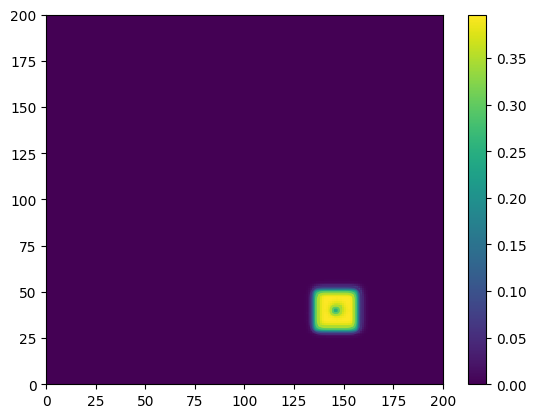

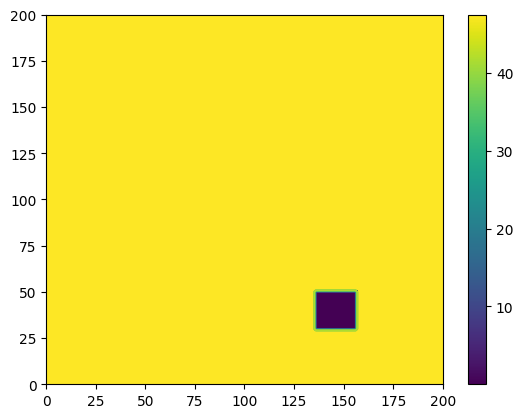

tensor([-201,   -1,  199, -200,  200, -199,    1,  201], device='cuda:0',
       dtype=torch.int32)


In [2]:
V =  values
C =  cost

V = V.detach().requires_grad_(True)
# C = C.detach().requires_grad_(True)

network = LaplaceNet((res, res), max_val, 1*cost_scale, 0)
network.C.data = C
out, _ =  network(grid, boundary_types, boundary_conditions)

# end = time.time()
# print(end - start)

loss = torch.sum((out)**2)
loss.backward()

# print(C.grad)
# print(V.grad)
# import sys
# np.set_printoptions(threshold=sys.maxsize)
# print(V.cpu().detach().numpy())
# print(V.grad.cpu().numpy())

# z = V.grad.cpu().detach().numpy()
# plt.pcolormesh(z)
# plt.colorbar()
# plt.contour(z)
# plt.show(
# )

z = network.C.grad.cpu().detach().numpy()
plt.pcolormesh(z)
plt.colorbar()
plt.contour(z)
plt.show()

V = out.detach()

z = V.cpu().detach().numpy()
plt.pcolormesh(z)
plt.colorbar()
plt.contour(z)
plt.show()

print(network.indexes)

# print(torch.cuda.memory_summary() )

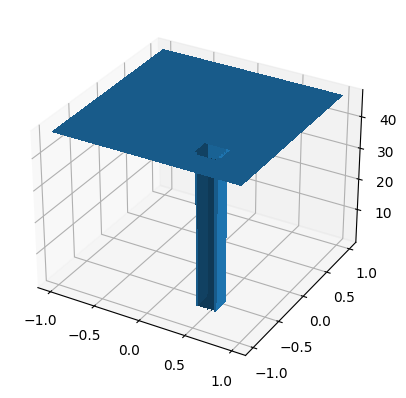

In [3]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
X = np.linspace(-1, 1, z.shape[0])
Y = np.linspace(-1, 1, z.shape[1])
X, Y = np.meshgrid(X, Y)
surf = ax.plot_surface(X,Y,z,linewidth=0, antialiased=False)

In [4]:
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
import torch.optim as optim
from laplacian_py.network import LaplaceNet, compute_loss, calculate_gradient

inds = values >= max_val

# class LaplaceNet(nn.Module):
#     def __init__(self):
#         super(LaplaceNet, self).__init__()
#         self.C = nn.Parameter(cost_scale*torch.ones(res,res,dtype=torch.float32, device='cuda'))
# #         self.V = [max_val*torch.ones((res, res),dtype=torch.float32, device='cuda')]
#         layer = LaplacianSolver()
#         self.solve = layer.apply
        
    
#     def forward(self, x):
# #         C_pos = 5*cost_scale*(torch.tanh(self.C) + 1)
# #         C_pos = cost_scale*(torch.exp(self.C))
#         C_pos = F.relu(self.C)
#         out = self.solve(x, C_pos)
#         out[out >= max_val] = .95*max_val
#         out[inds] = max_val
#         return out, C_pos

# def compute_loss(pred, target, C_pos):
# #     loss = F.huber_loss(pred, target)
#     loss = torch.sum((pred - target)**2)/pred.numel()
#     min_val = .1*cost_scale
#     if torch.any(C_pos[C_pos < min_val]):
#         loss = loss + 50*torch.sum((C_pos[C_pos < min_val] - .1*cost_scale)**2)/torch.sum(C_pos[C_pos < min_val])
#     return loss
    
V_in = V.clone()
network = LaplaceNet((res,res), max_val, 1*cost_scale, 0)
network.cuda(device='cuda')


LaplaceNet()

In [5]:
def compute_loss_grad(pred, grid, C_pos, cost_scale):
    J1, J2 = calculate_gradient(pred.unsqueeze(axis=0).unsqueeze(axis=0), grid)
    target = torch.tensor(50**grid/(torch.sqrt(torch.sum(grid**2, axis=3).unsqueeze(axis=3)) + .001), dtype=torch.float32, device='cuda')
    loss = 1*torch.sum(abs(J2 - target)) / pred.numel()
    min_val = cost_scale
#     loss += 100*torch.sum(C_pos**2)/C_pos.numel()
    if torch.any(C_pos < min_val):
        loss = loss + 1 * torch.sum((C_pos[C_pos < min_val] - min_val) ** 2) / torch.sum(
            C_pos[C_pos < min_val])
    return loss


tensor(137.0478, device='cuda:0', grad_fn=<MulBackward0>)
tensor(134.2245, device='cuda:0', grad_fn=<MulBackward0>)
tensor(122.7754, device='cuda:0', grad_fn=<MulBackward0>)
tensor(107.8712, device='cuda:0', grad_fn=<MulBackward0>)
tensor(95.0283, device='cuda:0', grad_fn=<MulBackward0>)
tensor(85.0029, device='cuda:0', grad_fn=<MulBackward0>)
tensor(77.1083, device='cuda:0', grad_fn=<MulBackward0>)
tensor(70.7388, device='cuda:0', grad_fn=<MulBackward0>)
tensor(65.4840, device='cuda:0', grad_fn=<MulBackward0>)
tensor(61.0671, device='cuda:0', grad_fn=<MulBackward0>)
tensor(57.2962, device='cuda:0', grad_fn=<MulBackward0>)
tensor(54.0366, device='cuda:0', grad_fn=<MulBackward0>)
tensor(51.1873, device='cuda:0', grad_fn=<MulBackward0>)
tensor(48.6730, device='cuda:0', grad_fn=<MulBackward0>)
tensor(46.4375, device='cuda:0', grad_fn=<MulBackward0>)
tensor(44.4371, device='cuda:0', grad_fn=<MulBackward0>)
tensor(42.6381, device='cuda:0', grad_fn=<MulBackward0>)
tensor(41.0129, device='cud

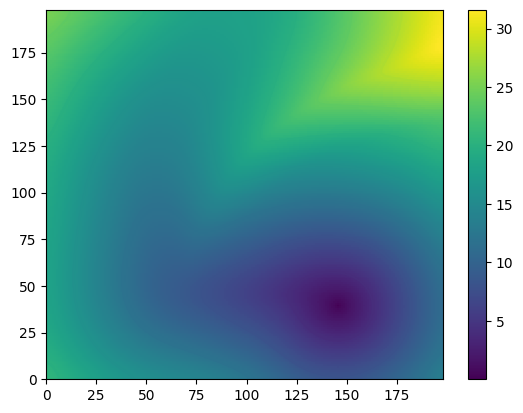

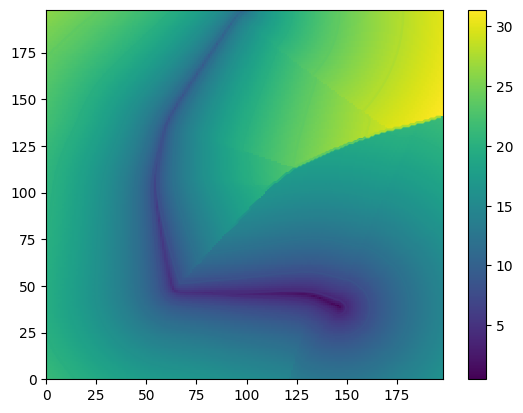

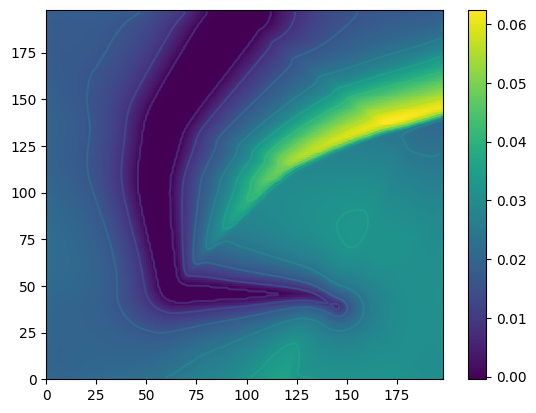

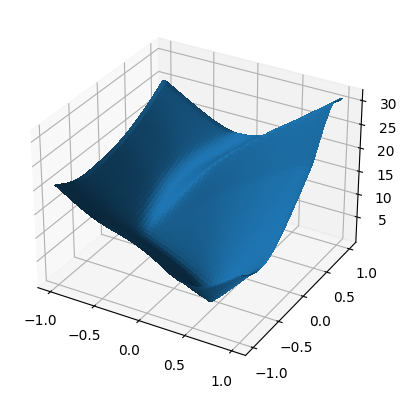

In [6]:
# lr = 5e-0 #huber
# lr = 1e-0 # norm
lr = 2e-5# normal
# lr = 1e-5# grad
momentum = 0.99
optimizer = optim.SGD(network.parameters(), lr=lr, momentum=momentum)

XYZ = [np.linspace(-1, 1, res, dtype=np.float32) for _ in range(2)]
X, Y = np.meshgrid(*XYZ)

# XYZ_train = XYZ
XYZ_train = [np.linspace(-1, 1, int(res), dtype=np.float32) for _ in range(2)]
X_train, Y_train = np.meshgrid(*XYZ_train)
out = np.stack([X_train, Y_train], axis=2)
grid_train = torch.tensor(out, dtype=torch.float32, device='cuda', requires_grad=True)
grid_train = grid_train.unsqueeze(axis=0)


# target = torch.tensor(20*Y + 20,dtype=torch.float32, device='cuda')
# target = torch.tensor(-20*X + 20,dtype=torch.float32, device='cuda')
# target = torch.tensor(6*((X+1)**2+(Y+1)**2) + 0,dtype=torch.float32, device='cuda')
# target = torch.tensor(15 + 0*X,dtype=torch.float32, device='cuda')
# target = torch.tensor(10*Y + 10*(1-X), dtype=torch.float32, device='cuda')
# target = torch.tensor(10*(1-Y) + 10*X, dtype=torch.float32, device='cuda')

from pykdtree.kdtree import KDTree
traj = np.load('demo.npy')
kd_tree = KDTree(traj)
query_point = grid_train.cpu().detach().numpy()
query_point = np.reshape(query_point, (-1,2))
dist, idx = kd_tree.query(query_point, k=1)
dist = np.sqrt(dist)
idx = np.max(idx)-idx
target = 20*dist + 10*(idx)/np.max(idx)  
target = torch.reshape(torch.tensor(target, dtype=torch.float32, device='cuda') , (res,res))

network.reset()
for i in range(1000):
    pred, C = network(grid_train, boundary_types, boundary_conditions)
    
# network.V = target
for it in range(0, 5000):
    optimizer.zero_grad()
    pred, C = network(grid_train, boundary_types, boundary_conditions)
    loss_train = 1*compute_loss(pred=pred, target=target, C=C, cost_scale=cost_scale)
#     loss_train = compute_loss_grad(pred=pred, grid=grid_train,  C_pos=C_pos, cost_scale=cost_scale)
    if it % 100 == 0:
        print(loss_train)
    loss_train.backward()
    optimizer.step()
    

pred, C = network(grid, boundary_types, boundary_conditions)
    
z = pred.cpu().detach().numpy()[1:-1, 1:-1]
plt.pcolormesh(z)
plt.colorbar()
plt.contour(z)
plt.show()


z2 = target.cpu().detach().numpy()[1:-1, 1:-1]
plt.pcolormesh(z2)
plt.colorbar()
plt.contour(z2)
plt.show()

z3 = C.cpu().detach().numpy()[1:-1, 1:-1]
plt.pcolormesh(z3)
plt.colorbar()
plt.contour(z3)
plt.show()

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
X = np.linspace(-1, 1, z.shape[0])
Y = np.linspace(-1, 1, z.shape[1])
X, Y = np.meshgrid(X, Y)
surf = ax.plot_surface(X,Y,z,linewidth=0, antialiased=False)


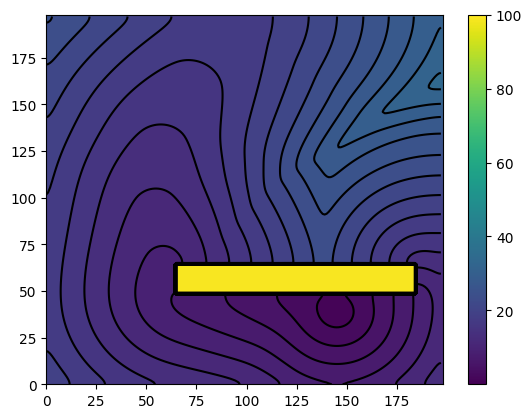

In [7]:
boundary_types_2 = boundary_types.clone()
boundary_conditions_2 = boundary_conditions.clone()

# obj1_ind1 = int(res*18/30)
# obj1_ind2 = int(res*2/3)
# obj1_ind3 = int(res*0)
# obj1_ind4 = int(res*2/3)
# boundary_conditions_2[obj1_ind1:obj1_ind2, obj1_ind3:obj1_ind4] = 2*max_val
# boundary_types_2[obj1_ind1:obj1_ind2, obj1_ind3:obj1_ind4] = 1.0

obj2_ind1 = int(res*3/12)
obj2_ind2 = int(res*4/12)
obj2_ind3 = int(res*1/3)
obj2_ind4 = int(res*28/30)
boundary_conditions_2[obj2_ind1:obj2_ind2, obj2_ind3:obj2_ind4] = 2*max_val
boundary_types_2[obj2_ind1:obj2_ind2, obj2_ind3:obj2_ind4] = 1.0


# obj1_ind1 = int(res*1/3)
# obj1_ind2 = int(res*2/3)
# obj1_ind3 = int(res*1/3)
# obj1_ind4 = int(res*2/3)
# boundary_conditions_2[obj1_ind1:obj1_ind2, obj1_ind3:obj1_ind4] = 2*max_val
# boundary_types_2[obj1_ind1:obj1_ind2, obj1_ind3:obj1_ind4] = 1.0


# boundary_types_2 = boundary_types
# boundary_conditions_2 = boundary_conditions
network.max_val = 5*max_val
network.reset()
for i in range(5000):
    pred, C_pos = network(grid, boundary_types_2, boundary_conditions_2)
    V_in = pred.detach()

z = pred.cpu().detach().numpy()[1:-1, 1:-1]
plt.pcolormesh(z)
plt.colorbar()
cs = plt.contourf(z, levels=list(np.linspace(np.min(z),np.max(z), 50)))
plt.contour(cs, colors='k')
plt.show()




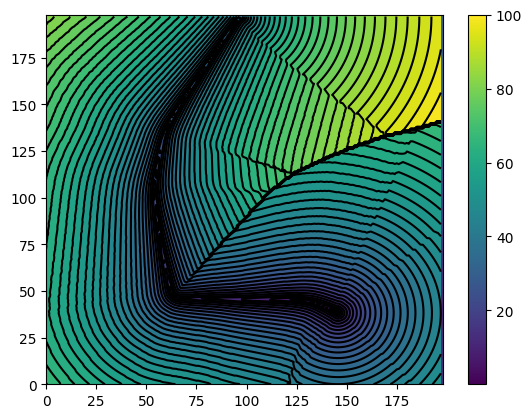

In [8]:
z2 = target.cpu().detach().numpy()[1:-1, 1:-1]
plt.pcolormesh(z)
plt.colorbar()
cs = plt.contourf(z2, levels=list(np.linspace(np.min(z2), np.max(z2), 50)))
plt.contour(cs, colors='k')
plt.show()


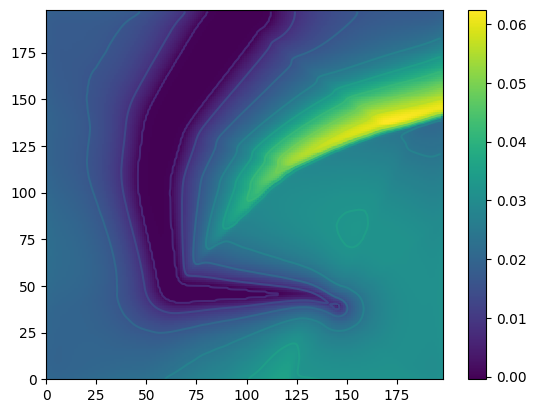

In [9]:
z3 = C_pos.cpu().detach().numpy()[1:-1, 1:-1]
z3[boundary_types[1:-1,1:-1].cpu().numpy() !=0] = 0
plt.pcolormesh(z3)
plt.colorbar()
plt.contour(z3)
plt.show()


In [10]:
# z3 = abs(z2-z)
# z3[boundary_types[1:-1,1:-1].cpu().numpy() !=0] = 1
# plt.pcolormesh(z3)
# plt.colorbar()
# plt.show()


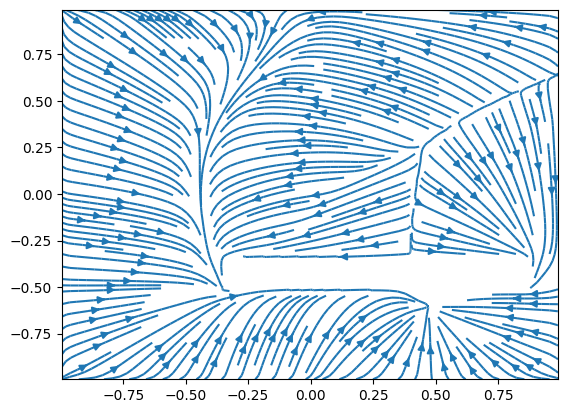

In [11]:
# z = pred.cpu().detach().numpy()[1:-1, 1:-1]
# Vp = -np.diff(z[:, 1:], axis=0)
# Up = -np.diff(z[1:, :], axis=1)
# plt.streamplot(X[1:, 1:], Y[1:, 1:], Up, Vp,density=2)
# plt.show()


tmp = [np.linspace(-1, 1, 2*res, dtype=np.float32) for _ in range(2)]
X_new, Y_new = np.meshgrid(*tmp)
out = np.stack([X_new, Y_new], axis=2)
query = torch.tensor(out, dtype=torch.float32, device='cuda', requires_grad=True)
query.unsqueeze(axis=0)
J1, J2 = calculate_gradient(pred[1:-1, 1:-1].unsqueeze(axis=0).unsqueeze(axis=0), query.unsqueeze(axis=0))
J2 = J2.cpu().detach().numpy()
Up = -J2[0, 1:-2, 1:-2, 0]
Vp = -J2[0, 1:-2, 1:-2, 1]
plt.streamplot(X_new[1:-2, 1:-2], Y_new[1:-2, 1:-2], Up, Vp, density=2)
plt.show()

In [12]:
# import sys
# np.set_printoptions(threshold=sys.maxsize)
# print(J2[:, 0:-1:10, 0:-1:1,:])



In [13]:
# torch.save(network.state_dict(), "network_2d.pt")

In [14]:
# network = LaplaceNet((res, res), max_val, .1*cost_scale, 0)
# network.load_state_dict(torch.load("network_2d.pt"))
# network.eval()

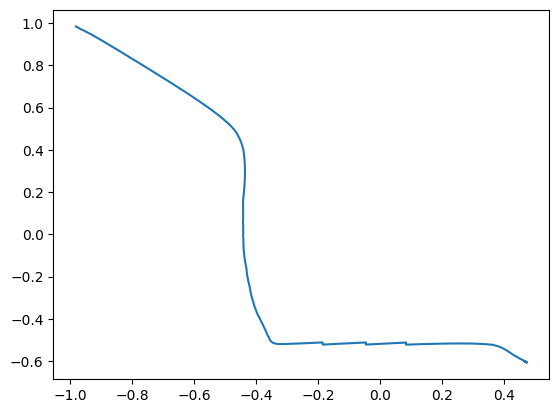

In [15]:
dt = 0.01
cur = np.reshape(np.array([-.99, .99]),(1,1,1,2))
traj = np.zeros((1000, 2))
for i in range(traj.shape[0]):
    query = torch.tensor(cur, dtype=torch.float32, device='cuda', requires_grad=True)
    query.unsqueeze(axis=0)
    J1, J2 = calculate_gradient(pred[1:-1, 1:-1].unsqueeze(axis=0).unsqueeze(axis=0), query)
    J2 = J2.cpu().detach().numpy()
    J2 = J2/np.linalg.norm(J2)
    cur += -J2*dt
    traj[i, :] = cur

    
plt.plot(traj[:,0], traj[:,1])

# # np.save('demo.npy', traj)